# <center>Moi ja tervetuloa kaikille aikasarjojen analysointiluentoon!</center>

![](https://gentlepacedotcodotuk.files.wordpress.com/2016/12/moomin-family.png?w=940&h=568&crop=1)

# <center>Time series analysis in Python</center>


## План
1. Введение 
  * Основные определения, варианты постановки задачи
  * Метрики качества прогнозов, R^2, MSE, MAE, MAPE и т.д.
2. Движемся, сглаживаем и оцениваем 
  * Rolling window estimations
  * Экспоненциальное сглаживание, простое, двойное и Holt-Winters
  * Кросс-валидация на временных рядах, подбор параметров + практика, оценка Holt-Winters с минимизацией ошибки на кросс-валидации на разных рядах
3. Эконометрический подход 
  * Стационарность и единичные корни - интуиция теории
  * Избавление от нестационарности, дифференцирование, сезонное дифференцирование, выделение трендов
  * ARIMA, немного интуиции, выбор начальных параметров модели по ACF, PACF, выбор параметров перебором, построение SARIMAX с подобранными параметрами
  * Ограничения, недостатки эконометрического подхода

# 1) Введение

При работе с временными рядами чаще всего возникает вопрос — а что у нас будет происходить с нашими показателями в ближайший день/неделю/месяц/пр. — сколько будет онлайна, как много действий совершат пользователи, и так далее. К задаче прогнозирования можно подходить по-разному, в зависимости от того, какого качества должен быть проноз, на какой период мы хотим его строить, и, конечно, как долго нужно подбирать и настраивать параметры модели для его получения.

Небольшое [определение](https://ru.wikipedia.org/wiki/Временной_ряд) временного ряда:
> Временной ряд – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки

Таким образом, данные оказываются упорядочены относительно неслучайных моментов времени, и, значит, в отличие от случайных выборок, могут содержать в себе дополнительную информацию, которую мы постараемся извлечь. 

В целом, задачи, связанные с временными рядами можно разбить на несколько групп
- Прогнозирование - когда хотим узнать, что будет дальше
- Поиск аномалий - когда хотим понять, где были проблемы в прошлом
- Кластеризация и классификация - когда временные ряды сами являются признаками объектов

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"] = [14, 10]

%config Completer.use_jedi = False

print("Imports Done!")

Imports Done!


In [2]:
PATH = '~/PycharmProjects/Datasets/'

In [3]:
ads = pd.read_csv(PATH + 'ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv(PATH +  'currency.csv', index_col=['Time'], parse_dates=['Time'])

In [4]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [5]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


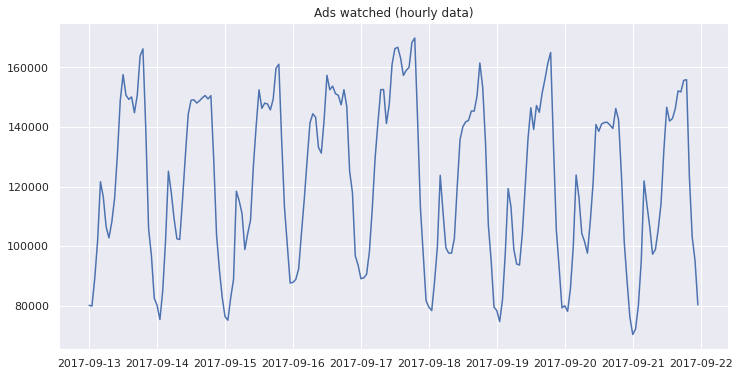

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

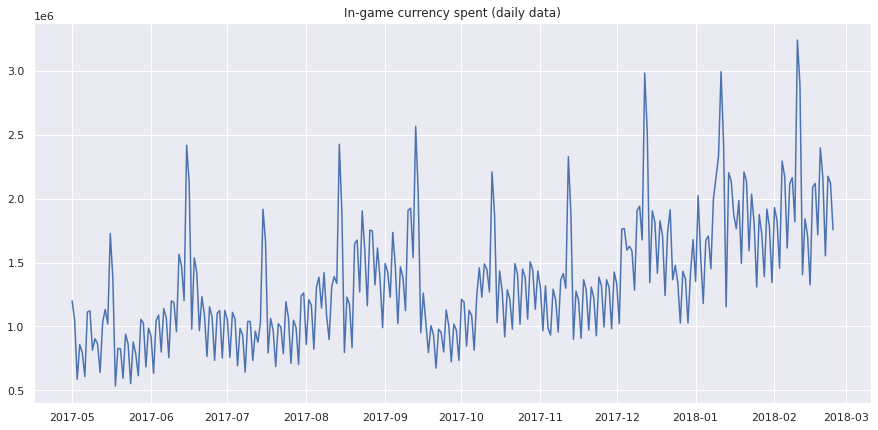

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

## Метрики качества прогноза

Рассмотрим основные и самые распространенные метрики качества прогнозов, которые, по большому счету, являются метриками для задачи регрессии и используются далеко не только во временных рядах.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination), коэффициент детерминации (в эконометрике - доля объясненной моделью дисперсии), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error), интерпретируемая метрика, измеряется в тех же единицах, что и исходный ряд, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error), также интерпретируемая метрика, однако её преимущество - нечувствительность (робастность) к выбросам в данных, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), используется в большинстве случаев, сильнее наказывает модель за большие ошибки и меньше - за маленькие (парабола), $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), практически тоже самое, но значения предварительно логарифмируются, таким образом маленьким ошибкам также уделяется значительное внимание, обычно используется, если данным присущ экспоненциальный рост, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error, как MAE, только в процентах, - удобно для объяснения заказчику качества прогноза, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [8]:
# импортируем всё, о чем говорили выше

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

Отлично, теперь мы знаем, как можно измерить качество нашего прогноза, какие метрики стоит применять и как объяснить содеянное заказчику, дело осталось за малым - нужно построить прогноз

# 2) Движемся, сглаживаем и оцениваем

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо модели вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений, а значит, воспользуемся скользящей средней. 

$$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$$

In [9]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

К сожалению, такой прогноз долгосрочным сделать не удастся, для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение - сглаживание исходного ряда для выявления трендов, в пандасе есть готовая реализация - [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Чем больше зададим ширину интервала - тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь увидеть общие паттерны.

In [10]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window, center=False).mean() #center=True

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Применим такое сглаживание к нашим рядам:

Сглаживание по последним 4 часам

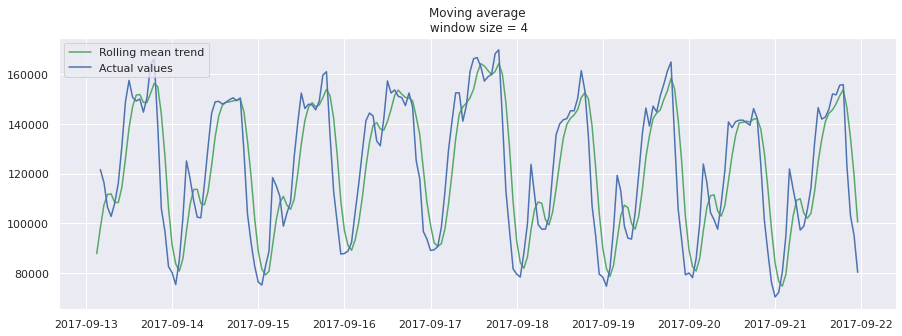

In [11]:
plotMovingAverage(ads, 4) 

По 12 часам (полдня)

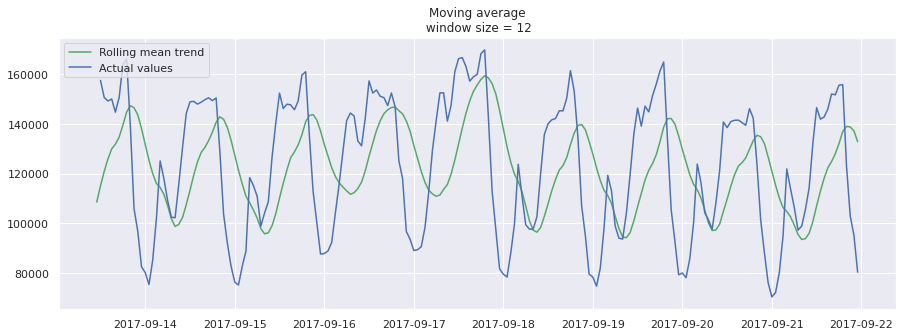

In [12]:
plotMovingAverage(ads, 12) 

Сглаживание по 24 часам (одни сутки) - выделяется дневной тренд

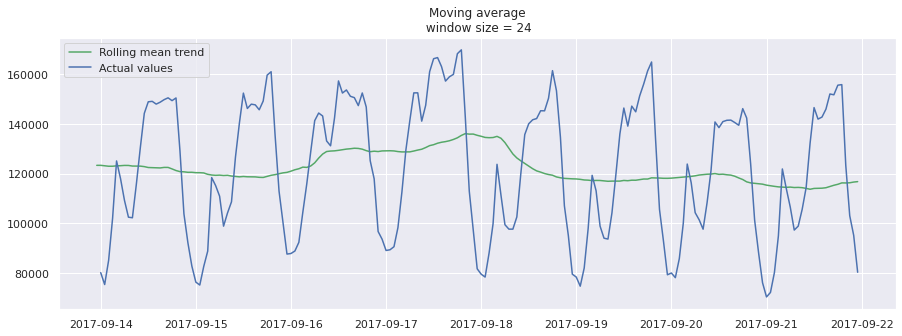

In [13]:
plotMovingAverage(ads, 24)

Также можно отобразить доверительные интервалы для наших средних значений

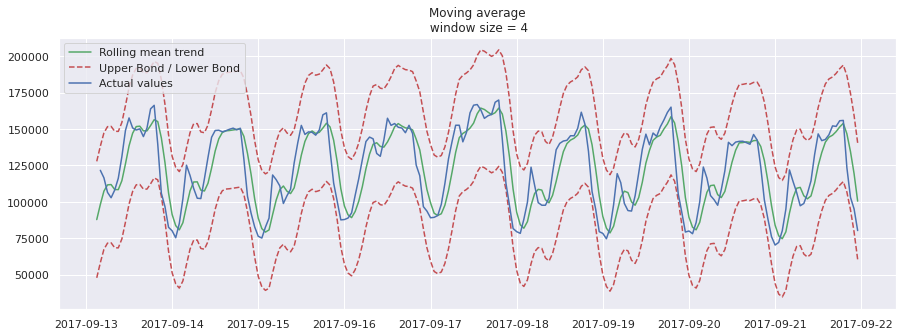

In [14]:
plotMovingAverage(ads, 4, plot_intervals=True)

А теперь попробуем при помощи этих доверительных интервалов поймать аномалию во временном ряде. К сожалению или к счастью, конкретно в этом ряду всё более-менее хорошо и гладко, поэтому аномальное значение мы зададим самостоятельно в датафрейме `ads_anomaly`

In [15]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

И посмотрим, удастся ли таким простым образом её поймать

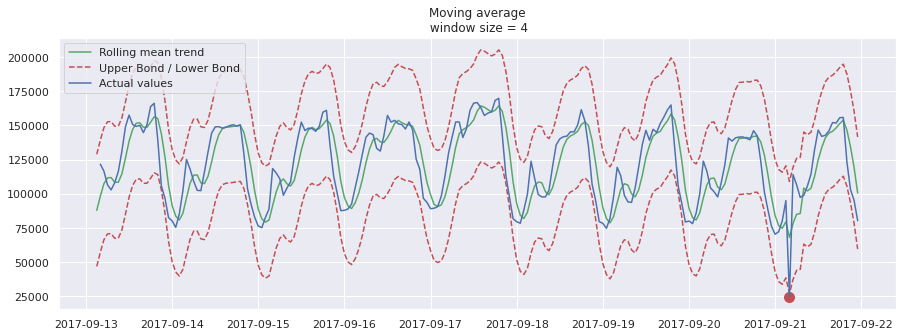

In [16]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

Тоже самое можно проделать и со вторым рядом, попробуем сгладить его с окном в 7 дней, то есть по неделям, и поймать аномалии

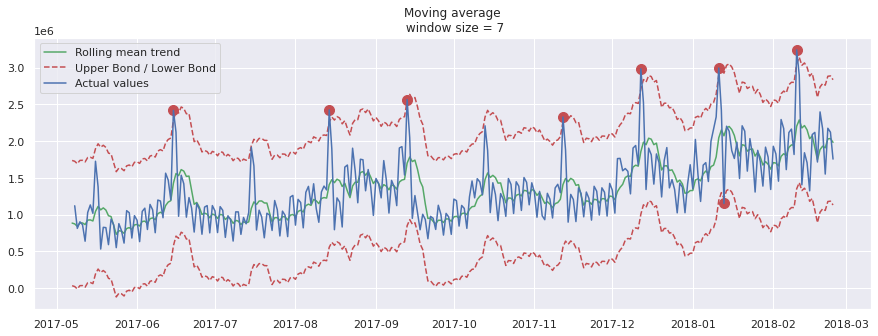

In [17]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в суме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес. 


$$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$$

In [18]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [19]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

## Экспоненциальное сглаживание

А теперь посмотрим, что произойдёт, если вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого [экспоненциального сглаживания](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [20]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [21]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

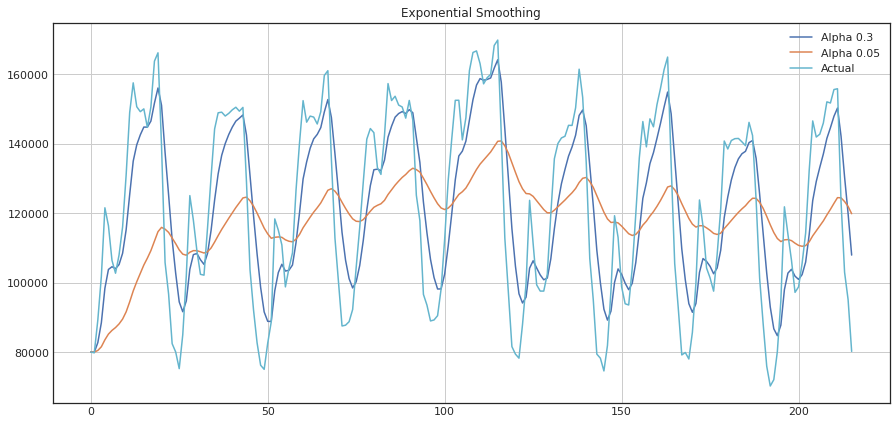

In [22]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

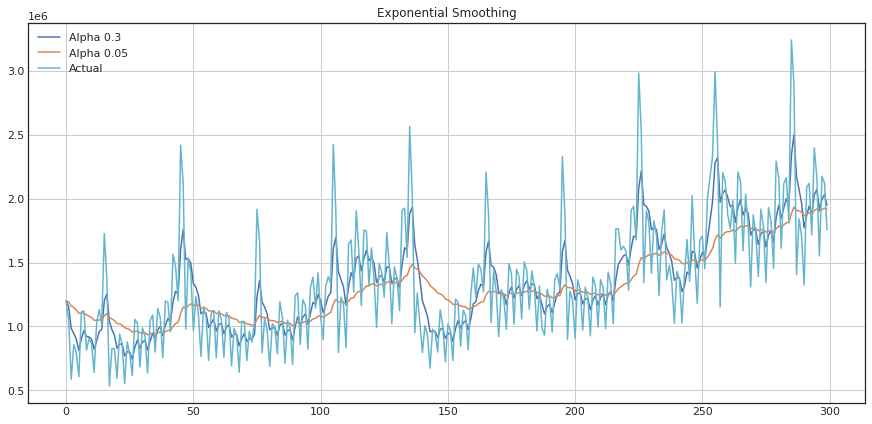

In [23]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

## Двойное экспоненциальное сглаживание

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед (и тоже красиво сглаживать ряд).

В этом нам поможет разбиение ряда на две составляющие - уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

В результате получаем набор функций. Первая описывает уровень - он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд - он зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [24]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseuture data ries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

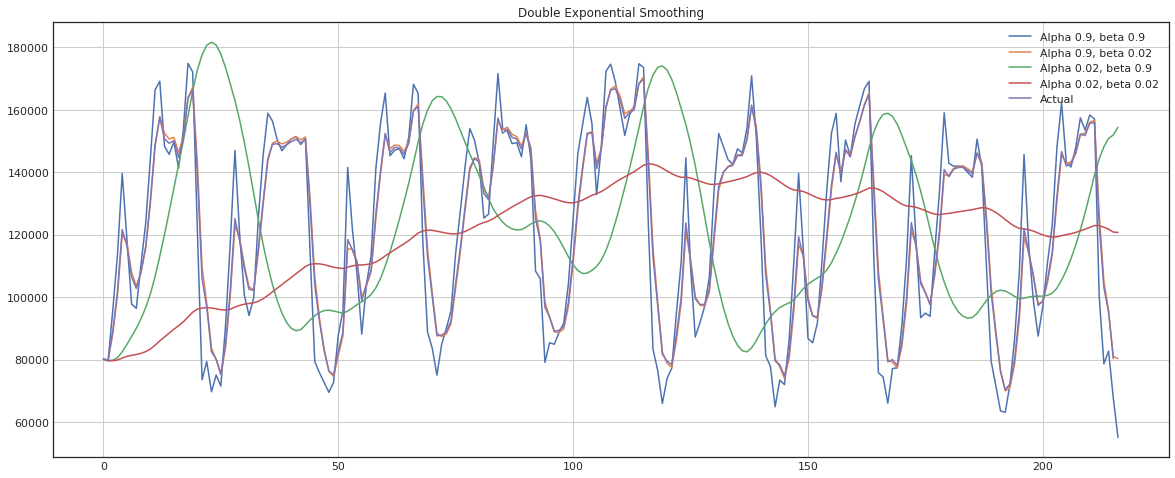

In [25]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

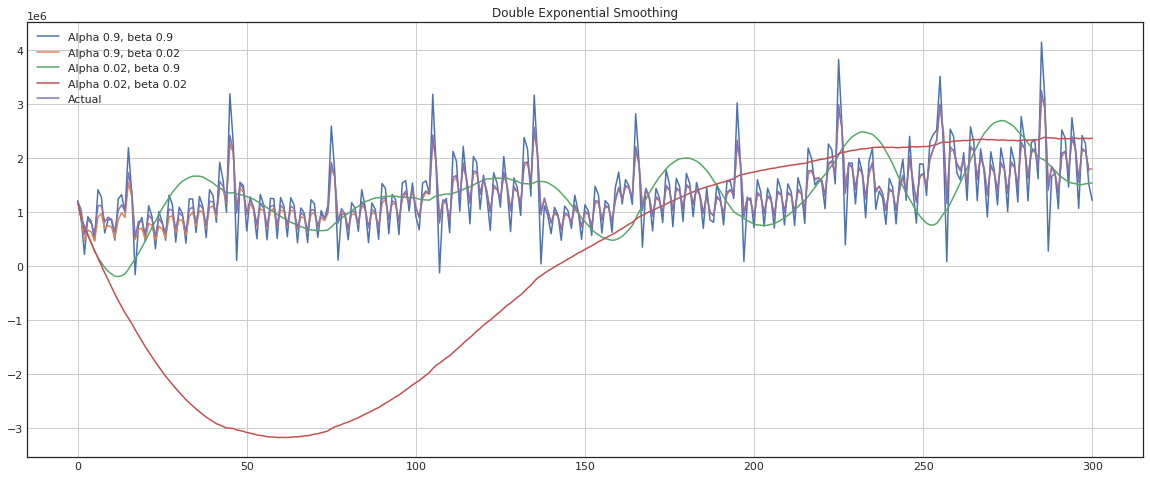

In [26]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Теперь у нас появилась возможность настраивать уже два параметра - $\alpha$ и $\beta$. Первый отвечает за сглаживание ряда вокруг тренда, второй - за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд. Комбинации параметров могут выдавать достаточно причудливые результаты, особенно если задавать их руками. 

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

Итак, успешно добрались до следующего варианта экспоненциального сглаживания, на сей раз тройного.

Идея этого метода заключается в добавлении еще одной, третьей, компоненты - сезонности. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона - периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем новую систему:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, от и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать [здесь](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд, что не может не радовать. 

Ниже импортируем класс для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей - Чарльза Хольта и его студента Питера Винтерса. 
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$$

где $T$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

In [27]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## Кросс-валидация на временных рядах

Перед тем, как построить модель, поговорим, наконец, о не ручной оценке параметров для моделей. 

Ничего необычного здесь нет, по-прежнему сначала необходимо выбрать подходящуюю для данной задачи функцию потерь, которая будет следить за качеством подгонки модели под исходные данные. Затем будем оценивать на кросс-валидации значение функции потерь при данных параметрах модели, искать градиент, менять в соответствии с ним параметры и бодро опускаться в сторону глобального минимума ошибки. 

Так как временной ряд внезапно имеет временную структуру, случайно перемешивать в фолдах значения всего ряда без сохранения этой структуры нельзя, иначе в процессе потеряются все взаимосвязи наблюдений друг с другом. Поэтому придется использовать чуть более хитрый способ для оптимизации параметров, официального названия которому я так и не нашел, но на сайте [CrossValidated](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection), предлагают название "cross-validation on a rolling basis", что не дословно можно перевести как кросс-валидация на скользящем окне.

Суть достаточно проста - начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого $t$, делаем прогноз на $t+n$ шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до $t+n$ значения и прогнозируем с $t+n$ до $t+2*n$, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько $n$ уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Теперь, зная, как настраивать кросс-валидацию, подберём с её помощью параметры для модели Хольта-Винтерса

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

https://stackoverflow.com/questions/50785479/holt-winters-time-series-forecasting-with-statsmodels

In [28]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

В модели Хольта-Винтерса, так же, как и в других моделях экспоненциального сглаживания, есть ограничение на величину сглаживающих коэффициентов. Каждый из них должен быть от 0 до 1. Соответственно, чтобы минимизировать нашу функцию потерь, нам нужно использовать метод, который поддерживает ограничения на оцениваемые параметры. В нашем случае это метод truncated Newton conjugate gradient

In [29]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11469082908652417 0.002411065117098432 0.08737400521651173
CPU times: user 2.42 s, sys: 14 ms, total: 2.43 s
Wall time: 2.42 s


In [30]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

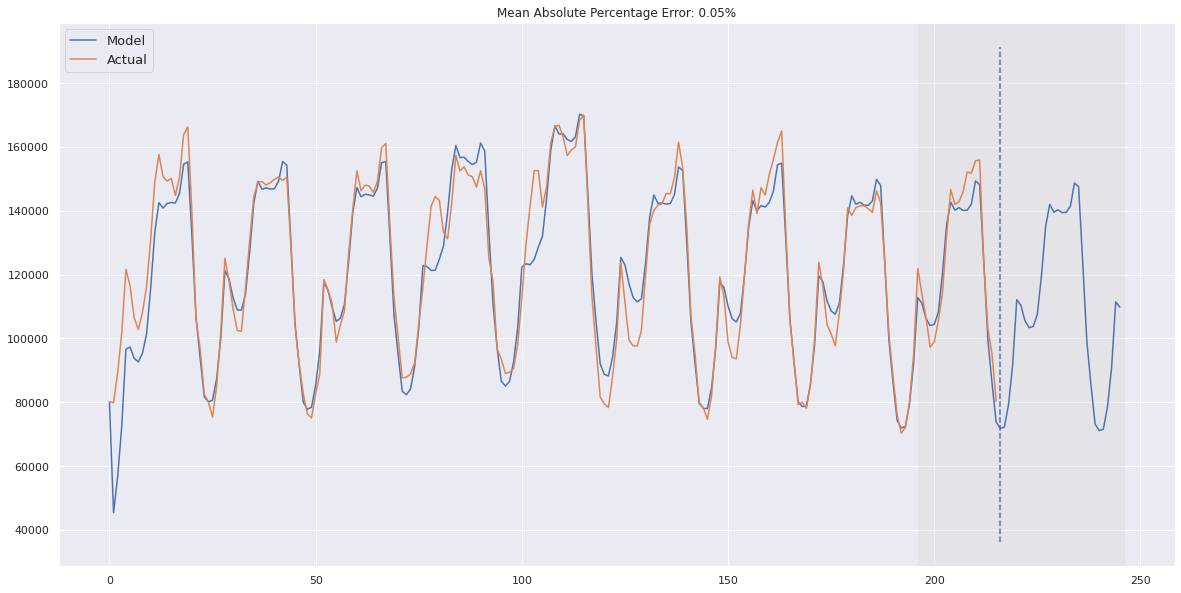

In [31]:
plotHoltWinters(ads.Ads)

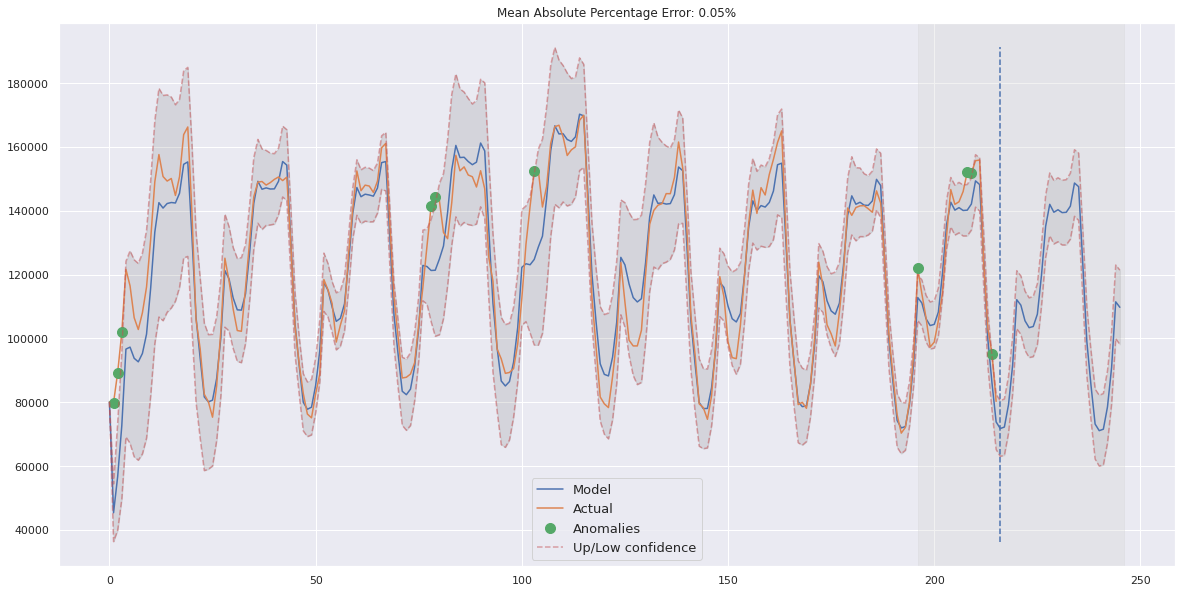

In [32]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

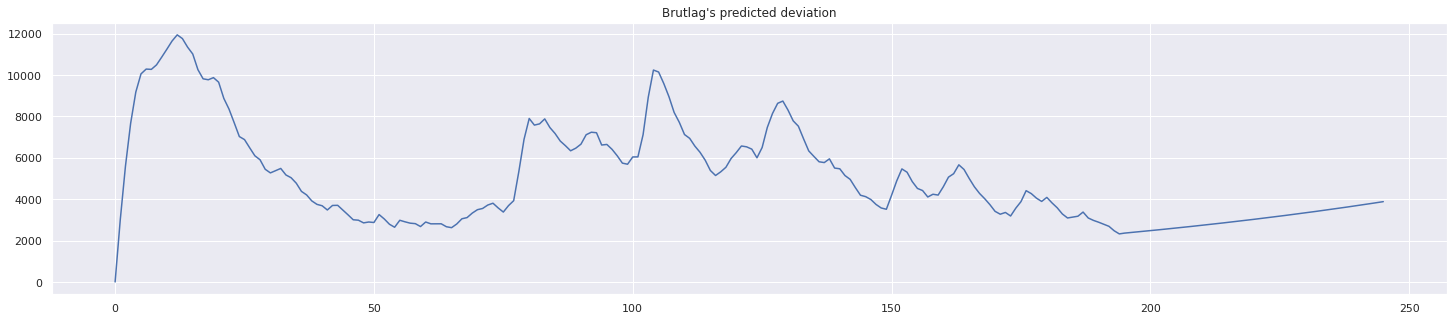

In [33]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

Прогоним тот же самый алгоритм для второго временного ряда, в котором, как мы знаем, есть тренд и месячная сезонность

In [42]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0.25] #3 - 0.25

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.010426002858552552 0.05691672504215334 0.06606562146609274
CPU times: user 2.97 s, sys: 503 µs, total: 2.97 s
Wall time: 2.98 s


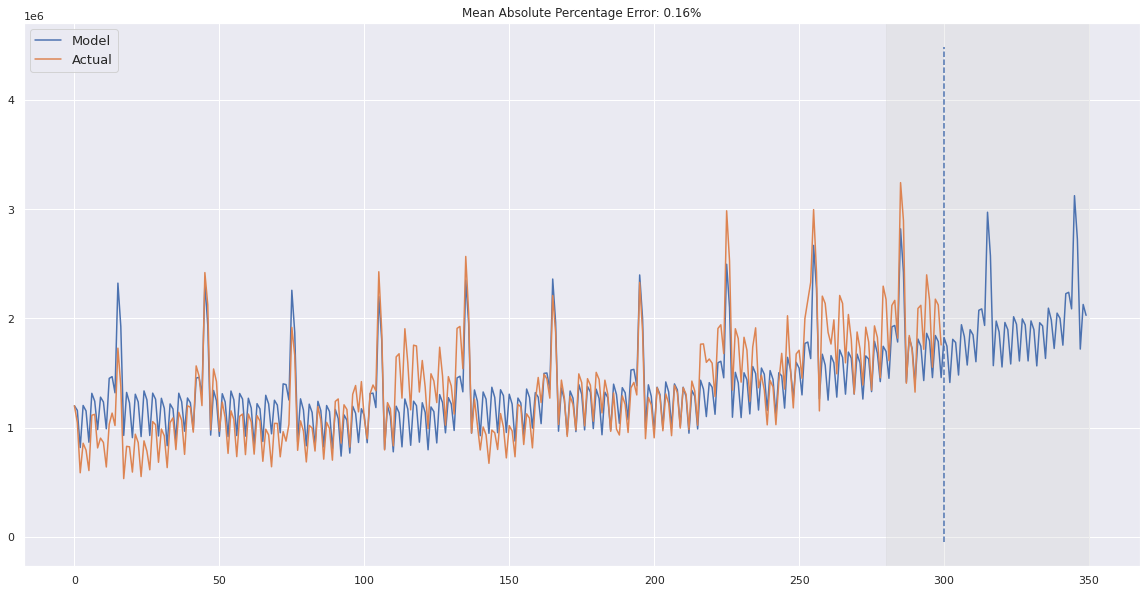

In [43]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

Выглядит весьма правдоподобно, модель уловила и восходящий тренд, и сезонные пики, и в целом достаточно точно описывает наш временной ряд

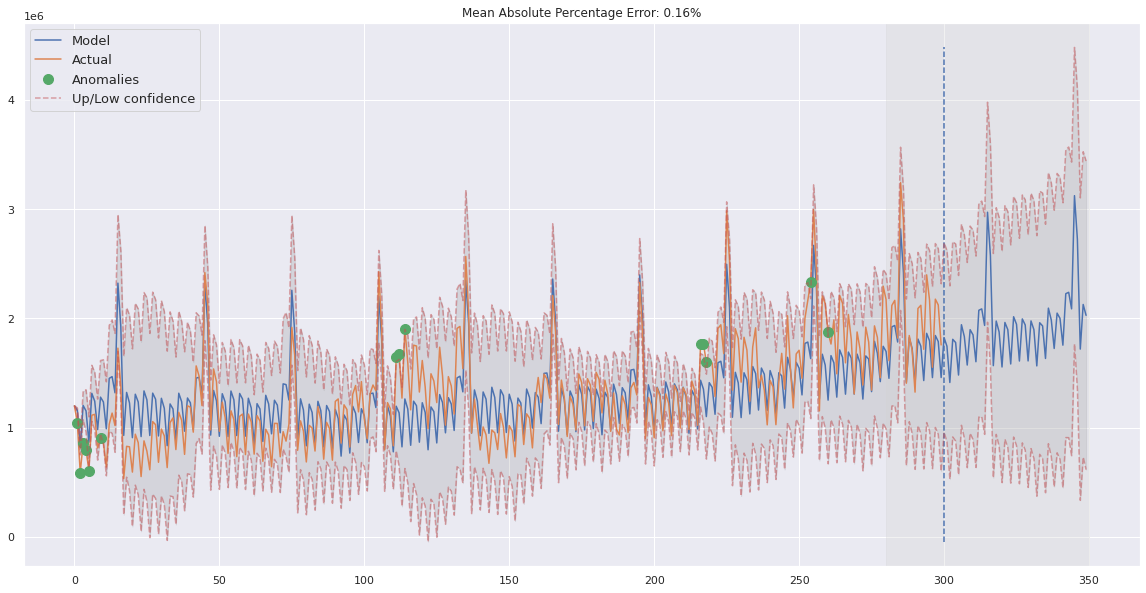

In [44]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

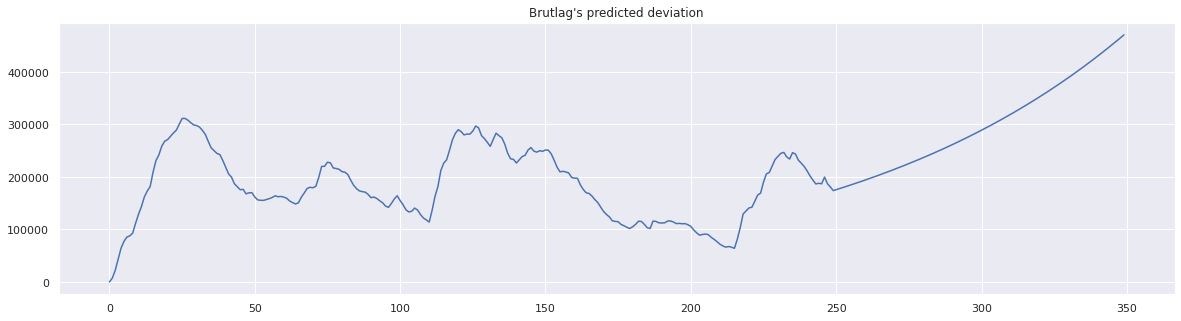

In [45]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

# 3) Эконометрический подход

### Стационарность

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как [**стационарность**](https://ru.wikipedia.org/wiki/Стационарность). 
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- Временной ряд справа не является стационарным, так как его матожидание со временем растёт

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Здесь не повезло с дисперсией - разброс значений ряда существенно варьируется в зависимости от периода

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Наконец, на последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

Чтобы бороться с нестационарностью, нужно узнать её в лицо, потому посмотрим, как её детектировать. Для этого обратимся к белому шуму и случайному блужданию, чтобы выяснить как попасть из одного в другое бесплатно и без смс.


График белого шума:

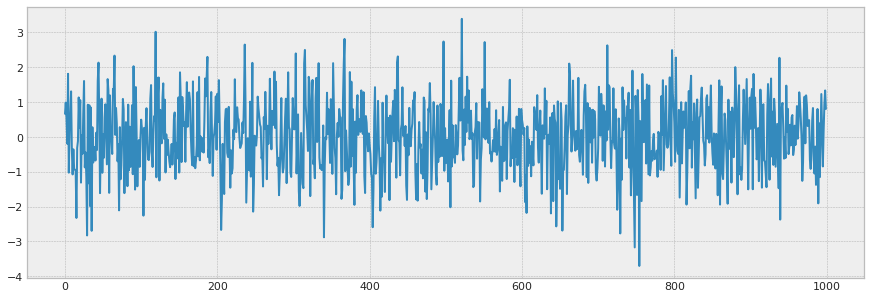

In [38]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля с отклонением в 1. Теперь на основании него сгенерируем новый процесс, в котором каждое последующее значение будет зависеть от предыдущего: $x_t = \rho x_{t-1} + e_t$ 

Here is the code to render the plots.

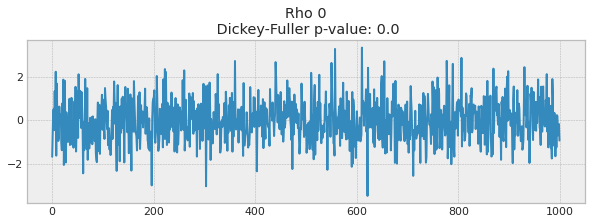

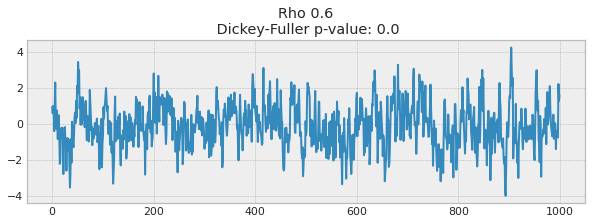

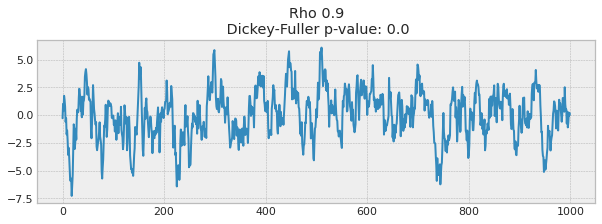

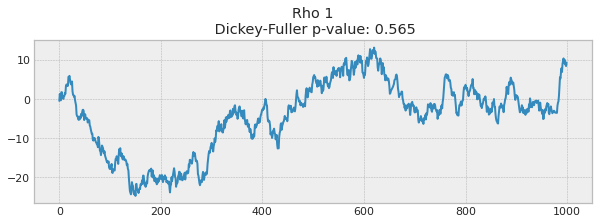

In [46]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

На первом графике получился точно такой же стационарный белый шум, который строился раньше. На втором значение  увеличилось до $0.6$, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. Наконец, значение  равное единице дало процесс случайного блуждания — ряд не стационарен.


Происходит это из-за того, что при достижении критической единицы, ряд $x_t = \rho x_{t-1} + e_t$ перестаёт возвращаться к своему среднему значению. Если вычесть из левой и правой части $x_{t-1}$, то получим  $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, где выражение слева — первые разности. Если $\rho=1$, то первые разности дадут стационарный белый шум $e_t$. Этот факт лёг в основу теста Дики-Фуллера на стационарность ряда (наличие единичного корня). Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка. Нулевая гипотеза теста — ряд не стационарен, отвергалась на первых трех графиках, и принялась на последнем. Стоит сказать, что не всегда для получения стационарного ряда хватает первых разностей, так как процесс может быть интегрированным с более высоким порядком (иметь несколько единичных корней), для проверки таких случаев используют расширенный тест Дики-Фуллера, проверяющий сразу несколько лагов.


Бороться с нестационарностью можно множеством способов — разностями различного порядка, выделением тренда и сезонности, сглаживаниями и преобразованиями, например, Бокса-Кокса или логарифмированием.

## Избавляемся от нестационарности и строим SARIMA

Попробуем теперь построить SARIMA модель, пройдя все ~~круги ада~~ стадии приведения ряда к стационарному виду. Подробно про саму модель можно почитать здесь - [Построение модели SARIMA с помощью Python+R](https://habrahabr.ru/post/210530/), [Анализ временных рядов с помощью python](https://habrahabr.ru/post/207160/)

In [47]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

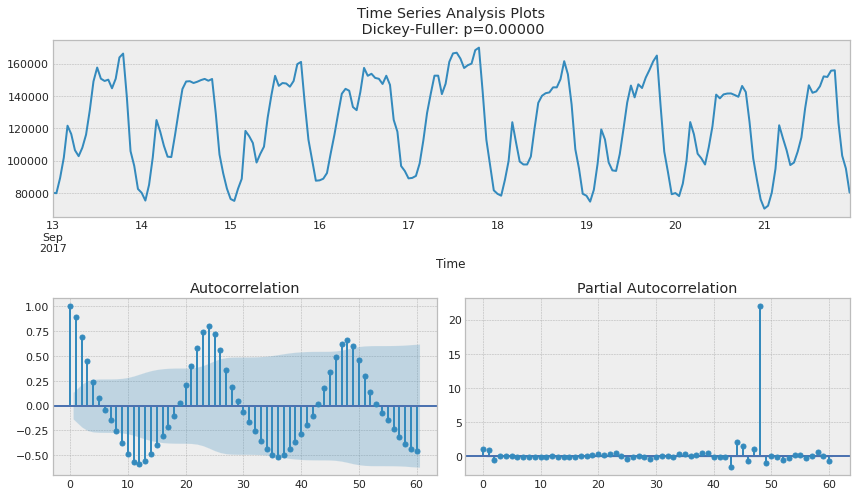

In [48]:
tsplot(ads.Ads, lags=60)

Отлично, этот ряд по критерию Дикки-Фуллера у нас стационарен, по его графику тоже видно, что тренд, как таковой, отсутствует, т.е., матожидание постоянно, разброс вокруг среднего тоже примерно одинаковый, значит, постоянство дисперсии также наблюдается. Остаётся сезонность, с которой нужно разобраться перед построением модели.
Для этого выполним преобразование под хитрым названием "сезонное дифференцирование", под которым скрывается простое вычитание из ряда самого себя с лагом равным периоду сезонности.

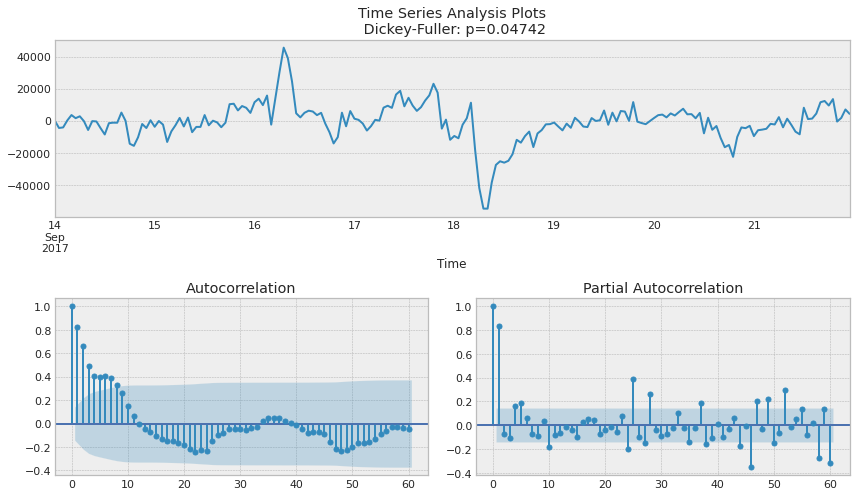

In [49]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

Уже лучше, от видимой сезонности избавились, в автокорреляционной функции по-прежнему осталось много значимых лагов, попробуем от них избавиться, взяв еще и первые разности - то есть вычитание ряда самого из себя с лагом в один шаг

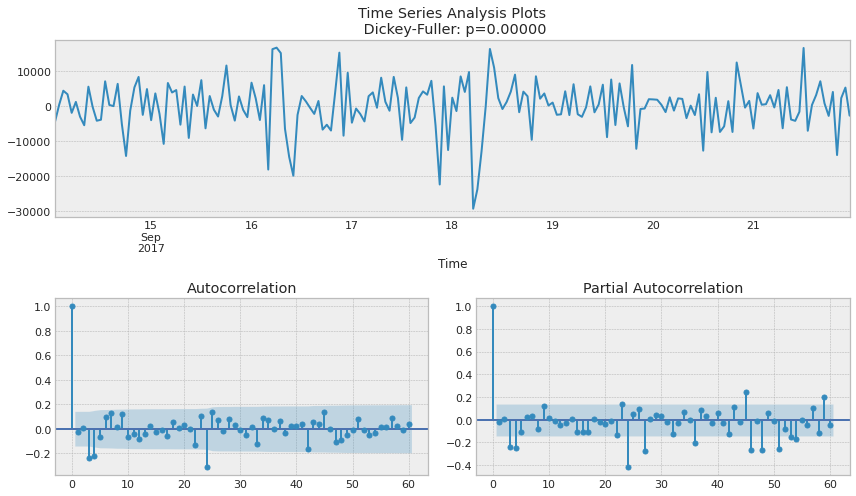

In [50]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Отлично, теперь ряд выглядит как непонятно что, колеблющееся вокруг нуля, по критерию Дикки-Фуллера он стационарен, а в автокорреляционной функции пропали многочисленные значимые пики. Можно приступать к моделированию! 

*Заметка*: Главное, чтобы значимых лагов было немного. 

## Экспресс-введение в ARIMA-семейство

Cовсем вкратце о самой модели. Начнём по буквам составлять это длинное название $SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

- $AR(p)$ - модель авторегрессии, т.е. регрессии временного ряда на самого себя, в основе лежит предположение о том, что временной ряд зависит от своих предыдущих значений с некоторым лагом (или с несколькими лагами), максимальный лаг, который входит в модель, обозначается буквой $p$. Определить начальное значение $p$ можно при помощи графика PACF по значимому лагу, после которого большинство оставшихся лагов становятся не значимыми.
- $MA(q)$ - модель скользящего среднего, если не вдаваться в детали - моделирует случайные ошибки временного ряда, т.е., как текущая ошибка во временном ряду зависит от предыдущих с некоторым лагом, здесь лаг обозначается буквой $q$. Начальное значение можно определить по графику ACF, логика аналогична.

Немножко остановимся и объединим первые четыре буквы, чтобы посмотреть, что у нас получилось:

$AR(p) + MA(q) = ARMA(p, q)$

А у нас получилась модель авторегрессии - скользящего среднего, если временной ряд стационарен, его можно смело аппроксимировать этими четырьмя буквами. Продолжим-с

- $I(d)$ - порядок интегрированности временного ряда. За этими словами стоит очень простая штука - сколько нам обычных разностей в ряде пришлось взять, чтобы привести его к стационарному, такой порядок интегрированности и будет. В нашем случае это единичка, так как мы взяли от нашего ряда первую разность. 

Добавим к нашим четырём буквам и получим модель $ARIMA$, которая умеет работать с нестационарными временными рядами, которые можно привести к стационарным при помощи взятия разностей некоторого порядка. Отлично, осталась последняя буква!

- $S(s)$ - эта буква отвечает за сезонность и равна длине периода сезонности во временном ряде

Прикрепляем последнюю букву и оказывается, что вместо одного дополнительного параметра у нас добавилось сразу три - $(P, D, Q)$

- $P$ - порядок модели авторегрессии для сезонной компоненты, также определяется по PACF, только смотреть нужно на число значимых лагов, кратных периоду сезонности, например, если период равен 24 и выясняется, что по PACF значим 24-й и 48-й лаг, то для начального приближения можно взять $P = 2$

- $Q$ - аналогично, но для модели скользящего среднего по сезонной компоненте, определяется по ACF

- $D$ - порядок сезонной интегрированности временного ряда. Может быть равен либо 0, либо 1, так как сезонное дифференцирование либо проводилось, либо нет

Теперь мы знаем, как подбирать параметры, еще раз посмотрим на график получившегося после преобразований стационарного ряда и попробуем подобрать начальные приближения параметров:

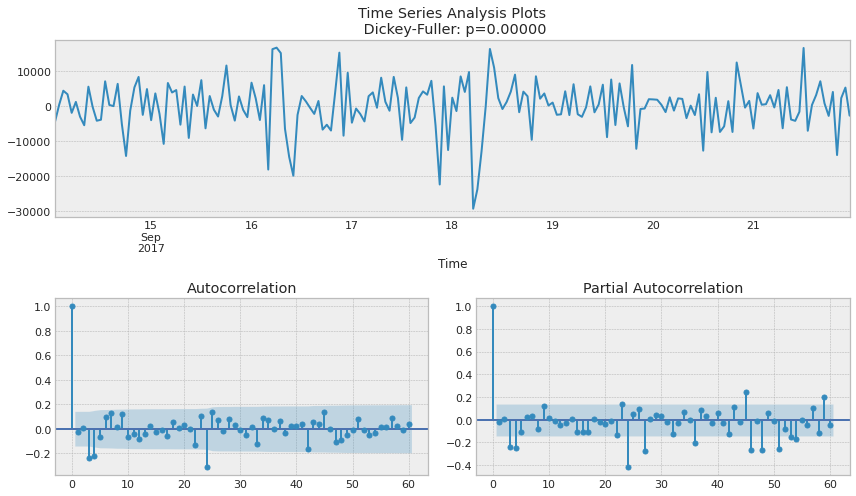

In [51]:
tsplot(ads_diff[24+1:], lags=60)

*Заметка*: Для параметра Р - смотрим значения лагов до первого сезона (24, в данном случае) по частной автокорреляции. Значимые лаги только 3 и 4. Значит, коэффициент можно взять либо 3, либо 4 - по номеру последнего значимого лага. 

Для параметра q - то же самое, но только по графику автокорреляции. 

Порог значимости - синяя трубка на графиках АКФ и ЧАКФ - выбирается как 0.05, типа как p-value.

In [ ]:
# p = 4
# d = 1
# q = 4

# P = 2
# D = 1
# Q = 1
# s = 24

Посмотрим, с какими параметрами модель будет лучше

In [52]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [53]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [54]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 22min 20s, sys: 19min 14s, total: 41min 34s
Wall time: 5min 33s


In [55]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


In [57]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Wed, 17 Feb 2021   AIC                           3888.642
Time:                                      21:31:40   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

Посмотрим на остатки модели:

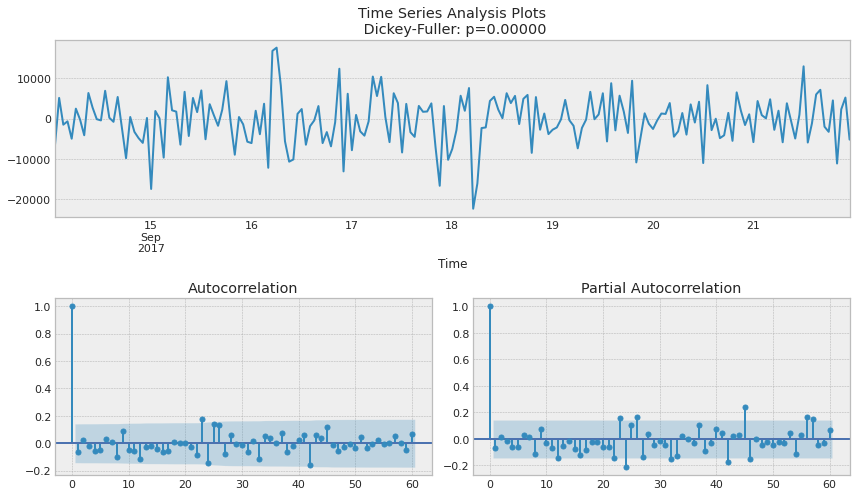

In [58]:
tsplot(best_model.resid[24+1:], lags=60)

Что ж, остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

In [59]:
def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = best_model.get_forecast(steps=50)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True);

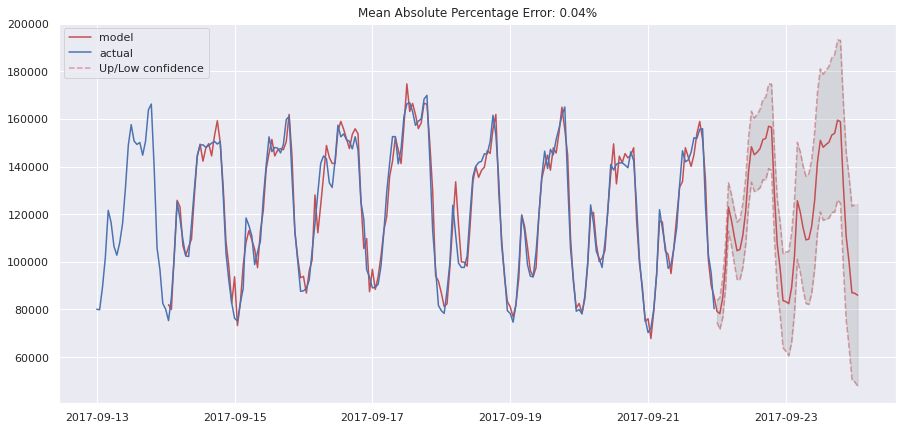

In [60]:
plotSARIMA(ads, best_model, 50, alpha=0.5)

В финале получаем очень хороший прогноз, заказчику средняя абсолютная ошибка в 4 процента также наверняка понравится, однако суммарные затраты на подготовку данных, приведение к стационарности, определение и перебор параметров могут такой точности и не стоить.

*Заметка*: Подходит для одномерного случая. Конечно, есть и расширения для многомерных случаев, но там свои тонкости. 